# **ResHedNet for Domain Walls Finding**

June, 2021


*   Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)

*   ResHedNet realized by [AtomAi](https://atomai.readthedocs.io/en/latest/) by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)

*   Analysis and implementation by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)





**Package Version**


*   AtomAi: 0.7.4
*   Numpy: 1.21.6
*   Matplotlib: 3.2.2
*   Torch: 1.11.0+cu113
*   CV2: 4.1.2





# **Install, Import, and Download**


*   Install and import required packages
*   Download train, test, and target PFM data set



In [ ]:
# !pip install imgaug==0.2.6
!pip install atomai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from atomai.utils import extract_patches_ 
import atomai as aoi

import torch
import torch.nn as nn
import torch.nn.functional as F


# **Prepare train data**


*   Extract subimages and corresponding labeled wall maps from images
*   Totally xxxx subimages and corresponding xxxx wall maps were prepared for training
*   All subimages and wall maps were spilted into 80% and 20% as train data and validation data, respectively.



Define a function to extract sub_ images and _labeled walls

In [ ]:
!gdown https://drive.google.com/uc?id=1RzOTj_ezsmrLs0jLJ8WdEjG9wYxLm5Of
!unzip pzt.zip

Downloading...
From: https://drive.google.com/uc?id=1RzOTj_ezsmrLs0jLJ8WdEjG9wYxLm5Of
To: /content/pzt.zip
100% 2.10M/2.10M [00:00<00:00, 204MB/s]
Archive:  pzt.zip
replace pzt/BEPFM_2um_0006.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: pzt/BEPFM_2um_0006.npy  
  inflating: pzt/BEPFM_2um_0006_label1.tif  
  inflating: pzt/BEPFM_2um_0007.npy  
  inflating: pzt/BEPFM_2um_0007_label1.tif  
  inflating: pzt/BEPFM_2um_0008.npy  
  inflating: pzt/BEPFM_2um_0008_label1.tif  
  inflating: pzt/BEPFM_2um_0009.npy  
  inflating: pzt/BEPFM_2um_0009_label1.tif  
  inflating: pzt/BEPFM_3um_0011.npy  
  inflating: pzt/BEPFM_3um_0011_label1.tif  
  inflating: pzt/BEPFM_3um_0012.npy  
  inflating: pzt/BEPFM_3um_0012_label1.tif  
  inflating: pzt/BEPFM_3um_0013.npy  
  inflating: pzt/BEPFM_3um_0013_label1.tif  
  inflating: pzt/BEPFM_3um_0014.npy  
  inflating: pzt/BEPFM_3um_0014_label1.tif  


In [ ]:
#title Define function: extract_subimage
def extract_subimage2 (x_train, y_train):
  #set patch number and patch size
  numpatches = 2000
  patchsize = 250

  #read and normalize x_train
  img = np.load(x_train)
  img = (img - img.min()) / img.ptp()
  noise = np.random.randn(256, 256)
  img = (img - img.min()) / img.ptp()

  #read and normalize y_train
  lab = plt.imread(y_train)
  if len(lab.shape) == 3:
    lab = lab[:,:,1]
  else:
    lab = lab
  lab = (lab - lab.min()) / lab.ptp()
  _, lab = cv2.threshold(lab, 0.7, 1, cv2.THRESH_BINARY)
  idx_ = np.asarray(np.where(lab==1))
  idx = idx_/(652/256)
  idx = idx.astype(int)
  lab = np.zeros((256,256))
  lab[idx[0,],idx[1,]]=1

  #generate training batch
  imgs, labs = extract_patches_(img, lab, patch_size=patchsize, num_patches=numpatches, random_state=42)

  #return subimage and label sets
  return imgs, labs

In [ ]:
#PZT
xtrain_load = ['pzt/BEPFM_2um_0006.npy',
               'pzt/BEPFM_2um_0007.npy',
               'pzt/BEPFM_2um_0008.npy',
               'pzt/BEPFM_2um_0009.npy',
               'pzt/BEPFM_3um_0011.npy',
               'pzt/BEPFM_3um_0012.npy', 
               'pzt/BEPFM_3um_0013.npy',
               'pzt/BEPFM_3um_0014.npy',]
ytrain_load = ['pzt/BEPFM_2um_0006_label1.tif',
               'pzt/BEPFM_2um_0007_label1.tif',
               'pzt/BEPFM_2um_0008_label1.tif',
               'pzt/BEPFM_2um_0009_label1.tif',
               'pzt/BEPFM_3um_0011_label1.tif',
               'pzt/BEPFM_3um_0012_label1.tif', 
               'pzt/BEPFM_3um_0013_label1.tif', 
               'pzt/BEPFM_3um_0014_label1.tif', ]

#set xtrain and ytrain datasets
xtrain = np.empty([0,250,250])
ytrain = np.empty([0,250,250])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage2(x_train = i, y_train = j)
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)

In [ ]:
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Show train and validation images

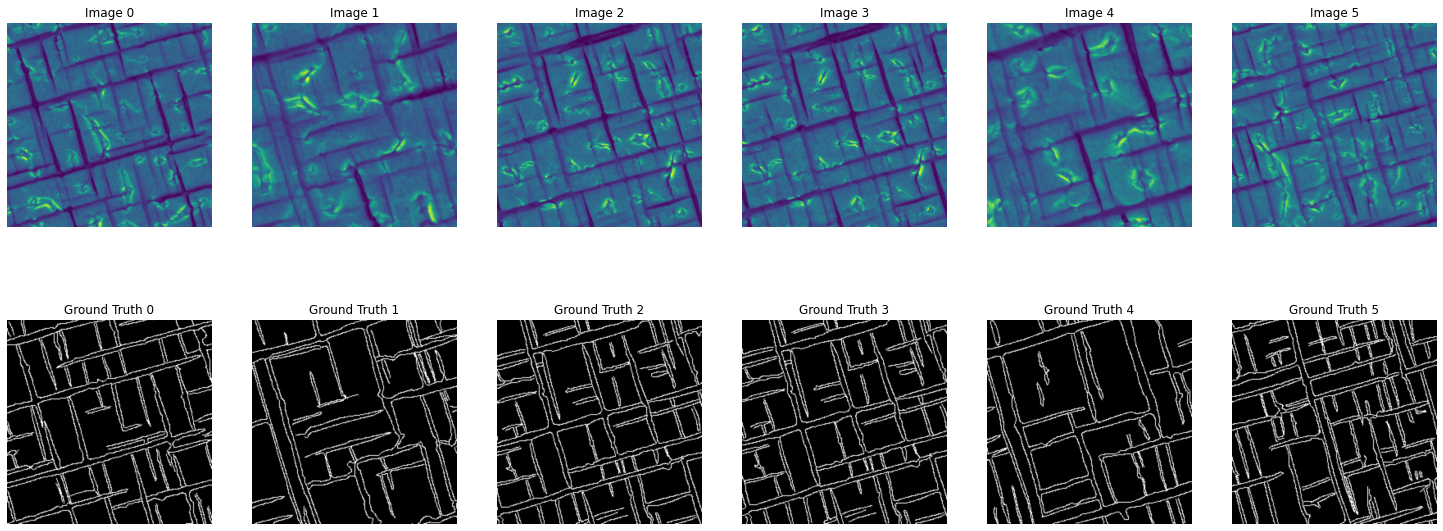

In [ ]:
# show training images
n = 5

n = n + 2
fig = plt.figure(figsize=(30, 10))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_train[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

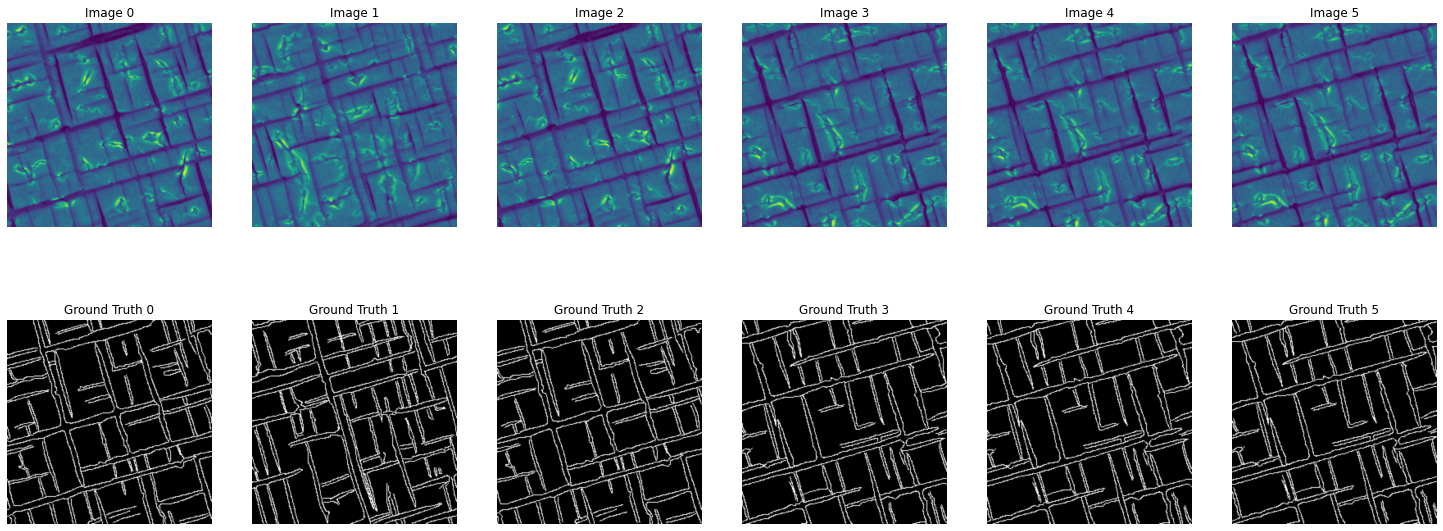

In [ ]:
# show validation images
n = 5

n = n + 2
fig = plt.figure(figsize=(30, 10))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_val[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1))
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

## **Define and train the model**



In [ ]:
etrainer = aoi.trainers.EnsembleTrainer("ResHedNet", nb_classes=1)
etrainer.compile_ensemble_trainer(
    training_cycles=800, loss='focal', batch_size=10, compute_accuracy=True, swa=True)

In [ ]:
augment_fn = aoi.transforms.seg_augmentor(
    nb_classes=1, contrast=True, blur=True, rotation=True)

Training ensemble models (strategy = 'from_scratch')

Ensemble model 1
Epoch 1/800 ... Training loss: 0.1518 ... Test loss: 0.0841 ... Train Accuracy: 0.2584 ... Test Accuracy: 0.3487 ... GPU memory usage: 8693/16280
Epoch 100/800 ... Training loss: 0.0472 ... Test loss: 0.0448 ... Train Accuracy: 0.5496 ... Test Accuracy: 0.5622 ... GPU memory usage: 8693/16280
Epoch 200/800 ... Training loss: 0.03 ... Test loss: 0.0301 ... Train Accuracy: 0.598 ... Test Accuracy: 0.6063 ... GPU memory usage: 8693/16280
Epoch 300/800 ... Training loss: 0.0208 ... Test loss: 0.0217 ... Train Accuracy: 0.6085 ... Test Accuracy: 0.6035 ... GPU memory usage: 8693/16280
Epoch 400/800 ... Training loss: 0.0146 ... Test loss: 0.0139 ... Train Accuracy: 0.6191 ... Test Accuracy: 0.6099 ... GPU memory usage: 8693/16280
Epoch 500/800 ... Training loss: 0.0116 ... Test loss: 0.0135 ... Train Accuracy: 0.6148 ... Test Accuracy: 0.6127 ... GPU memory usage: 8693/16280
Epoch 600/800 ... Training loss: 0.0096 ... Te

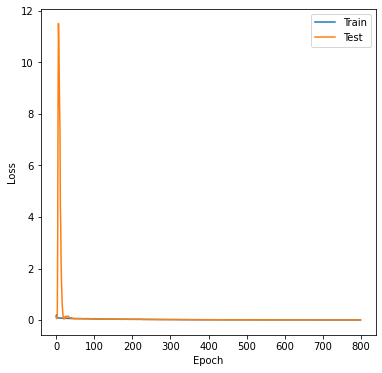


Ensemble model 2
Epoch 1/800 ... Training loss: 0.1299 ... Test loss: 0.0698 ... Train Accuracy: 0.3398 ... Test Accuracy: 0.4394 ... GPU memory usage: 8777/16280
Epoch 100/800 ... Training loss: 0.0464 ... Test loss: 0.0382 ... Train Accuracy: 0.5543 ... Test Accuracy: 0.5668 ... GPU memory usage: 8779/16280
Epoch 200/800 ... Training loss: 0.0279 ... Test loss: 0.0217 ... Train Accuracy: 0.6113 ... Test Accuracy: 0.6034 ... GPU memory usage: 8779/16280
Epoch 300/800 ... Training loss: 0.019 ... Test loss: 0.0196 ... Train Accuracy: 0.6226 ... Test Accuracy: 0.6185 ... GPU memory usage: 8779/16280
Epoch 400/800 ... Training loss: 0.0132 ... Test loss: 0.0131 ... Train Accuracy: 0.6382 ... Test Accuracy: 0.6241 ... GPU memory usage: 8779/16280
Epoch 500/800 ... Training loss: 0.0108 ... Test loss: 0.0095 ... Train Accuracy: 0.6304 ... Test Accuracy: 0.6293 ... GPU memory usage: 8779/16280
Epoch 600/800 ... Training loss: 0.0088 ... Test loss: 0.0083 ... Train Accuracy: 0.6315 ... Test

In [ ]:
smodel, ensemble = etrainer.train_ensemble_from_scratch(
    x_train, y_train, x_val, y_val, n_models=10, augment_fn=augment_fn,
    filename='Ensemble_ResHedNet_DWs_pzt') 

Make precition on validation images and compare with ground truth

In [ ]:
test = np.load("/content/pzt/BEPFM_2um_0009.npy")
test = (test-test.min())/test.ptp()

predictor = aoi.predictors.EnsemblePredictor(smodel, ensemble, nb_classes=1)
pred_mean, pred_var = predictor.predict(test)

pred_mean.shape, pred_var.shape

In [ ]:
f,(ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
f.subplots_adjust(hspace=0.01, top = 0.97)
f.suptitle("Step 256", fontsize = 20)
ax0.imshow(test)
ax0.axis ('off')
ax0.set_title('Amplitude', fontsize = 20)
ax1.imshow(pred_mean.squeeze(), cmap = 'gray')
ax1.axis('off')
ax1.set_title('Prediction', fontsize = 20)
ax2.imshow(pred_var.squeeze(), cmap = 'gray')
ax2.axis('off')
ax2.set_title('Uncertainty', fontsize = 20)
f.tight_layout()

Prediction with individual ensemble models:

In [ ]:
for m in ensemble.values():
    smodel.load_state_dict(m)
    p = aoi.predictors.SegPredictor(smodel, use_gpu=True)
    pred = p.predict(t)
    _,(ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    ax0.imshow(t)
    ax0.axis ('off')
    ax0.set_title('Image', fontsize = 20)
    ax1.imshow(pred.squeeze(), cmap = 'gray')
    ax1.axis('off')
    ax1.set_title('Prediction', fontsize = 20)
    plt.show()
    